In [50]:
from datasets import load_dataset

dataset_train = load_dataset("lex_glue", "ecthr_a", split="train")
dataset_validation = load_dataset("lex_glue", "ecthr_a", split="validation")
dataset_test = load_dataset("lex_glue", "ecthr_a", split="test")

Reusing dataset lex_glue (C:\Users\hustl\.cache\huggingface\datasets\lex_glue\ecthr_a\1.0.0\c3c0bd7433b636dc39ae49a84dc401190c73156617efc415b04e9835a93a7043)
Reusing dataset lex_glue (C:\Users\hustl\.cache\huggingface\datasets\lex_glue\ecthr_a\1.0.0\c3c0bd7433b636dc39ae49a84dc401190c73156617efc415b04e9835a93a7043)
Reusing dataset lex_glue (C:\Users\hustl\.cache\huggingface\datasets\lex_glue\ecthr_a\1.0.0\c3c0bd7433b636dc39ae49a84dc401190c73156617efc415b04e9835a93a7043)


In [51]:
#Get feature information...
dataset_train.info.features
#dataset_train.info

{'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'labels': Sequence(feature=ClassLabel(num_classes=10, names=['2', '3', '5', '6', '8', '9', '10', '11', '14', 'P1-1'], id=None), length=-1, id=None)}

In [52]:
def reprocess_data(raw_dataset,dataset_type):
#find all the sets where there are more than 1 labels
#and reprocess them into the origianl dataset, do that
#only records with single lables ecists
    redefined_dataset=[]
    fileIndex=0
    for x in raw_dataset:
        if(len(x["labels"])==1):            
            redefined_dataset.append({"text":" ".join(x["text"]).encode("ascii", "ignore").decode(),"labels":"LABEL-" + str(x["labels"][0])})
            fileIndex=fileIndex+1
            
        if(len(x["labels"])==0):
            redefined_dataset.append({"text":" ".join(x["text"]).encode("ascii", "ignore").decode(),"labels":"No-LABEL"})
            fileIndex=fileIndex+1
            
        if(len(x["labels"])>1):
            for y in x["labels"]:               
                redefined_dataset.append({"text":" ".join(x["text"]).encode("ascii", "ignore").decode(),"labels":"LABEL-" + str(y)})
                fileIndex=fileIndex+1
        
    return redefined_dataset

redefined_dataset_train= reprocess_data(dataset_train,"train")
redefined_dataset_validation= reprocess_data(dataset_validation,"validation")
redefined_dataset_test= reprocess_data(dataset_test,"test")

In [53]:
print(redefined_dataset_train[2]["labels"])

LABEL-3


In [54]:
import pandas as pd
train_df = pd.DataFrame(redefined_dataset_train)
val_df = pd.DataFrame(redefined_dataset_validation)
test_df = pd.DataFrame(redefined_dataset_test)
train_df.head(14)

,text,labels
0,11. At the beginning of the events relevant t...,LABEL-4
1,9. The applicant is the monarch of Liechtenst...,No-LABEL
2,9. In June 1949 plots of agricultural land ow...,LABEL-3
3,"8. In 1991 Mr Duan Slobodnk, a research worke...",LABEL-6
4,"9. The applicant is an Italian citizen, born ...",No-LABEL
5,12. In 1987 the applicant association publish...,LABEL-6
6,12. In 1987 the applicant association publish...,LABEL-3
7,7. The applicants are former members of the T...,LABEL-3
8,7. The circumstances in which the applicants ...,LABEL-0
9,7. The circumstances in which the applicants ...,LABEL-2


In [55]:
# Distribution of labels in training data
train_df.labels.value_counts()

LABEL-3     4704
LABEL-9     1421
LABEL-2     1368
LABEL-1     1349
No-LABEL     914
LABEL-4      710
LABEL-0      505
LABEL-6      291
LABEL-8      141
LABEL-7      110
LABEL-5       41
Name: labels, dtype: int64

In [56]:
# Convert abstract text lines into lists - i.e. get the texts from the datasets
train_texts = train_df["text"].tolist()
val_texts = val_df["text"].tolist()
test_texts = test_df["text"].tolist()
len(train_texts), len(val_texts), len(test_texts)

(11554, 1235, 1243)

In [57]:
#View first 3 texts of train_texts
#train_texts[:3]

In [58]:
# Extract labels ("labels" columns) and encode them into integers 
# So that LABEL-0 becomes 0, LABEL-1 1...No-LABEL=10 etc....
# So train_labels_encoded will contain an array in the same order as train_texts
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["labels"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["labels"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["labels"].to_numpy())

In [59]:
# Check what training labels look like
train_labels_encoded

array([ 4, 10,  3, ...,  3,  9,  3])

In [60]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(11,
 array(['LABEL-0', 'LABEL-1', 'LABEL-2', 'LABEL-3', 'LABEL-4', 'LABEL-5',
        'LABEL-6', 'LABEL-7', 'LABEL-8', 'LABEL-9', 'No-LABEL'],
       dtype=object))

### SKLEARN MODELLING

In [61]:
#We use sklern to build a simple model using a pipeline that contains TfidfVectorizer and MultinomialNB

#TfidfVectorizer -- Term Frequency – Inverse Document vectorizer which converts the text to numbers that can be computed

#MultinomialNB -- The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). 
#The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. 
#It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_texts, 
            y=train_labels_encoded);

In [62]:
# Evaluate baseline on validation dataset
model_0.score(X=val_texts,
              y=val_labels_encoded)

0.2493927125506073

In [63]:
# Make predictions  -- model_0.predict() takes an array of texts and returns an array of labels

baseline_preds = model_0.predict(val_texts)
baseline_preds

array([3, 3, 3, ..., 3, 3, 3])

In [64]:
# Download helper functions script
# Get a function for calculating results from the baseline predictions from the validation data
import urllib.request
url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'
filename = 'helper_functions.py'
urllib.request.urlretrieve(url, filename)

('helper_functions.py', <http.client.HTTPMessage at 0x28a434c32e0>)

In [65]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [66]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

C:\Users\hustl\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 24.93927125506073,
 'precision': 0.21566771923225403,
 'recall': 0.2493927125506073,
 'f1': 0.10788775434330616}

### TENSORFLOW MODDELING

In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [68]:
# How long is each text on average?
text_lens = [len(text.split()) for text in train_texts]
avg_text_len = np.mean(text_lens)
avg_text_len # return average sentence length (in tokens)

1795.4989613986497

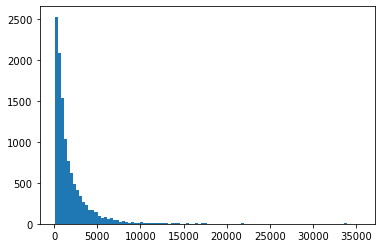

In [69]:
# What does the distribution look like?
import matplotlib.pyplot as plt
plt.hist(text_lens, bins=100);

#Most of the texts have almost 10,000 words

In [70]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(text_lens, 95))
output_seq_len

5813

In [71]:
# Maximum sentence length in the training set
max(text_lens)

35395

In [72]:
# How many words are in our vocabulary? 
max_tokens = 120000

In [73]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,       # number of words in vocabulary
                                    output_sequence_length=35416) # desired output length of vectorized sequences 
                                                                 # number of words per text
                                                                 # we could try 35416, being the max text length

In [74]:
# Adapt text vectorizer to training texts
text_vectorizer.adapt(train_texts)

In [75]:
# Test out text vectorizer
import random
target_text = random.choice(train_texts)
print(f"Text:\n{target_text}")
print(f"\nLength of text: {len(target_text.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_text])}")

Text:
4.  The applicant was born in 1963 and lives in Warsaw. 5.  On 18 December 2003 the applicant was arrested by the police on suspicion of having committed assault causing death and dealing in stolen goods. 6.  On 19 December 2003 the Warsaw District Court (Sd Rejonowy) remanded him in custody. It relied on a reasonable suspicion that the applicant had committed the offences with which he had been charged and on the risk that he might induce witnesses to give false testimony. Further, the court referred to the likelihood of a severe prison sentence being imposed on the applicant. 7.  In the course of investigation, the applicants detention was extended by the Ostroka Regional Court (Sd Okrgowy) on 4 March 2004, 11 May 2004 and 10 December 2004. In its decisions, the court relied on the likelihood that the applicant had committed the offence while acting with numerous co-suspects in the ambit of the activities of an organised criminal group. Further, it referred to the need to obtai

In [76]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 104748
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'to']
Least common words in the vocabulary: ['00076', '0005', '00012', '00003', '0000']


In [77]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 120000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 35416,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [78]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [79]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_text}\n")
vectorized_text = text_vectorizer([target_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_text}\n")
embedded_text = token_embed(vectorized_text)
print(f"Sentence after embedding:\n{embedded_text}\n")
print(f"Embedded sentence shape: {embedded_text.shape}")

Sentence before vectorization:
4.  The applicant was born in 1963 and lives in Warsaw. 5.  On 18 December 2003 the applicant was arrested by the police on suspicion of having committed assault causing death and dealing in stolen goods. 6.  On 19 December 2003 the Warsaw District Court (Sd Rejonowy) remanded him in custody. It relied on a reasonable suspicion that the applicant had committed the offences with which he had been charged and on the risk that he might induce witnesses to give false testimony. Further, the court referred to the likelihood of a severe prison sentence being imposed on the applicant. 7.  In the course of investigation, the applicants detention was extended by the Ostroka Regional Court (Sd Okrgowy) on 4 March 2004, 11 May 2004 and 10 December 2004. In its decisions, the court relied on the likelihood that the applicant had committed the offence while acting with numerous co-suspects in the ambit of the activities of an organised criminal group. Further, it refe

In [80]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(text_lens, 95))
output_seq_len

5813

In [83]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [84]:
#!pip install --upgrade tensorflow-estimator==2.3.0

In [85]:
# Test out the embedding on a random text
random_training_text = random.choice(train_texts)
print(f"Random training text:\n{random_training_text}\n")
use_embedded_text = tf_hub_embedding_layer([random_training_text])
print(f"Text after embedding:\n{use_embedded_text[0][:30]} (truncated output)...\n")
print(f"Length of text embedding:\n{len(use_embedded_text[0])}")

Random training text:
5.  On 13 June 2007 the Ust-Ilimsk Town Court of the Irkutsk Region found the applicant guilty of inflicting grave bodily harm which caused the death of the victim and sentenced him to a prison term. The applicant appealed, claiming in general terms that the proceedings had been unfair, and that the court had applied domestic law and assessed the evidence erroneously. He further alleged that the court had failed to examine two witnesses and had delivered its judgment in the absence of one of the codefendants. 6.  On 1 October 2007 the Irkutsk Regional Court quashed the conviction on appeal and remitted the case to the first-instance court for a fresh examination. 7.  On 20 March 2009 the Ust-Ilimsk Town Court found the applicant guilty of the same offence and gave him a custodial sentence. The applicant appealed. Giving no further details, he alleged that the Town Court had applied domestic law and assessed the evidence erroneously, and that it had rejected the ma

In [86]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["labels"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["labels"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["labels"].to_numpy().reshape(-1, 1))

In [87]:
# Check what training labels look like
train_labels_one_hot[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [88]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_texts, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_texts, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(11,), dtype=tf.float64, name=None))>

In [89]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 11), dtype=tf.float64, name=None))>

In [90]:
# Inspect training dataframe
train_df.head()

,text,labels
0,11. At the beginning of the events relevant t...,LABEL-4
1,9. The applicant is the monarch of Liechtenst...,No-LABEL
2,9. In June 1949 plots of agricultural land ow...,LABEL-3
3,"8. In 1991 Mr Duan Slobodnk, a research worke...",LABEL-6
4,"9. The applicant is an Italian citizen, born ...",No-LABEL


In [98]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(7, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)



# 2. Combine token and char embeddings into a hybrid embedding
combined_embeddings = token_model.output
z = layers.Dense(64, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(0.5)(z)
#z = layers.Dense(64, activation="relu")(z)
#z = layers.Dropout(0.5)(z)
    
    
# 3. Create output layer
output_layer = layers.Dense(11, activation="softmax", name="output_layer")(z)

# 4. Put together model
model_5 = tf.keras.Model(inputs=[#line_number_model.input,
                                 #total_line_model.input,
                                 token_model.input,
                                 ],
                                 outputs=output_layer)

In [99]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_inputs (InputLayer)   [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
 dense_3 (Dense)             (None, 64)                512       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                           

In [100]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000028A58928C70> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x0000028A6EA90DC0> False
<keras.layers.core.dense.Dense object at 0x0000028A588E36D0> True
<keras.layers.core.dense.Dense object at 0x0000028A390E03A0> True
<keras.layers.regularization.dropout.Dropout object at 0x0000028A6E8C6F70> True
<keras.layers.core.dense.Dense object at 0x0000028A4BC96910> True
<keras.layers.regularization.dropout.Dropout object at 0x0000028A67AC6850> True
<keras.layers.core.dense.Dense object at 0x0000028A390E0550> True


In [101]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [102]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((#train_line_numbers_one_hot, # line numbers
                                                                #train_total_lines_one_hot, # total lines
                                                                train_texts#, # train tokens
                                                                #train_chars
                                                                )) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((#val_line_numbers_one_hot,
                                                              #val_total_lines_one_hot,
                                                              val_texts#,
                                                              #val_chars
                                                              ))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 11), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 11), dtype=tf.float64, name=None))>)

In [104]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=15,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset))
                             )

Epoch 1/15
36/36 [==============================] - 11s 307ms/step - loss: 1.8715 - accuracy: 0.4948 - val_loss: 1.9608 - val_accuracy: 0.3958
Epoch 2/15
36/36 [==============================] - 10s 271ms/step - loss: 1.7210 - accuracy: 0.5590 - val_loss: 1.9516 - val_accuracy: 0.3750
Epoch 3/15
36/36 [==============================] - 8s 229ms/step - loss: 1.6961 - accuracy: 0.5434 - val_loss: 1.9557 - val_accuracy: 0.3438
Epoch 4/15
36/36 [==============================] - 9s 243ms/step - loss: 1.6932 - accuracy: 0.5347 - val_loss: 1.9400 - val_accuracy: 0.3646
Epoch 5/15
36/36 [==============================] - 10s 288ms/step - loss: 1.7809 - accuracy: 0.4766 - val_loss: 1.9373 - val_accuracy: 0.3646
Epoch 6/15
36/36 [==============================] - 10s 281ms/step - loss: 1.7242 - accuracy: 0.5234 - val_loss: 1.9348 - val_accuracy: 0.4062
Epoch 7/15
36/36 [==============================] - 13s 353ms/step - loss: 1.7910 - accuracy: 0.4991 - val_loss: 1.9209 - val_accuracy: 0.3854
E

36/36 [==============================] - 1s 31ms/step - loss: 1.7838 - accuracy: 0.4412 - val_loss: 1.8600 - val_accuracy: 0.4271


In [97]:
# Save best performing model to SavedModel format (default)
model_5.save("model5_model") # model will be saved to path specified by string

INFO:tensorflow:Assets written to: model5_model\assets


INFO:tensorflow:Assets written to: model5_model\assets
